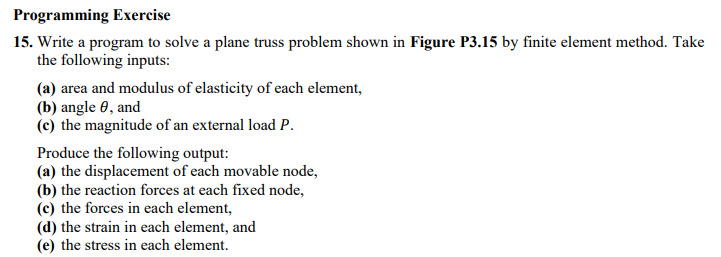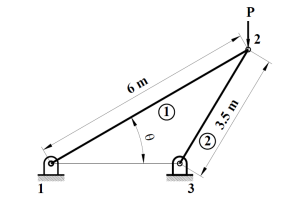

In [4]:
import numpy as np

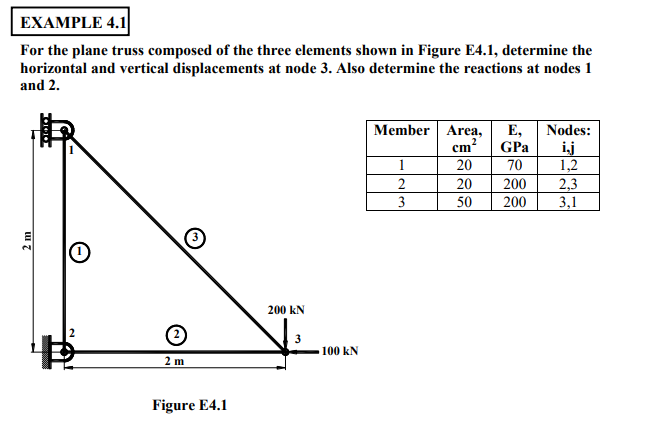

In [17]:
area = [20,20,50]
modulus_elasticity = [70, 200, 200]
theta = [-90, 0,135]
P = 100
length = [2, 2, 2.8284]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[1,3]}
load_status = {3:[-100,-200]}
node_status = {1:[0,0], 2:[0,0], 3:[1,1]}

In [43]:
def element_stiffness(modulus_elasticity, length, area, theta):
    # stiffness = np.zeros((4,4),dtype = 'int')
    C = np.round(np.cos(np.radians(theta)),2)
    S = np.round(np.sin(np.radians(theta)),2)
    # print(C)
    # print(S)
    # print("_______________")
    # print(modulus_elasticity)
    # print(length)
    # print(area)
    # print(theta)
    stiffness = (modulus_elasticity*area/length)*np.array([[C*C, C*S, -C*C, -C*S],
                                                           [C*S, S*S, -C*S, -S*S],
                                                           [-C*C, -C*S, C*C, C*S],
                                                           [-C*S, -S*S, C*S, S*S]
                                                           ])
    # print('here')
    # print(stiffness)
    return stiffness

def global_stiffness_matrix(stiffness_list, n_nodes, element_connection):
    global_stiffness = np.zeros((n_nodes, n_nodes), dtype = 'float')
    for n,stiffness in enumerate(stiffness_list):
        # print(stiffness)
        active_element = n+1
        i, j = element_connection[active_element]
        i = i*2-2
        j = j*2-2
        # print(i)
        # print(j)
        # print("Global stiffness subarrays:")
        # print("Left (i:i+2, i:i+2):\n", global_stiffness[i:i+2, i:i+2])
        # print("Right (j:j+2, j:j+2):\n", global_stiffness[j:j+2, j:j+2])

        # # Stiffness matrix slices to be added/subtracted
        # print("\nStiffness matrix slices:")
        # print("Left (0:2, 0:2):\n", stiffness[0:2, 0:2])
        # print("Right (2:, 2:):\n", stiffness[2:, 2:])
        
        # print("Global stiffness subarrays:")
        # print("Left (i:i+2, i:i+2):\n", global_stiffness[i+2:i+4, j+2:j+4])
        # print("Right (j:j+2, j:j+2):\n", global_stiffness[j+2:j+4, i+2:j+4])

        # # Stiffness matrix slices to be added/subtracted
        # print("\nStiffness matrix slices:")
        # print("Left (0:2, 2:):\n", stiffness[0:2, 2:])
        # print("Right (2:, 0:2):\n", stiffness[2:, 0:2])

        global_stiffness[i:i+2, i:i+2] += stiffness[0:2, 0:2]
        # print(global_stiffness)
        global_stiffness[j:j+2, j:j+2] += stiffness[2:,2:]
        # print(global_stiffness)
        global_stiffness[i:i+2, j:j+2] += stiffness[0:2, 2:]
        # print(global_stiffness)
        global_stiffness[j:j+2, i:i+2] += stiffness[2:,0:2]
        # print(global_stiffness)
    return global_stiffness
        
        
def vectors(node_status, load_status):
    n_nodes = len(node_status)*2
    disp = np.zeros((n_nodes,1), dtype = 'float')
    load_vec = np.zeros((n_nodes,1), dtype = 'float')
    fixed_node_pos = []
    flexible_node_pos = []
    for node,status in node_status.items():
        i = node*2-2
        if(not status[0]):
            fixed_node_pos.append(i)
        else:
            flexible_node_pos.append(i)
        if(not status[1]):
            fixed_node_pos.append(i+1)
        else:
            flexible_node_pos.append(i+1)
    for node, load in load_status.items():
        i = node*2-2
        load_vec[i], load_vec[i+1] = load
    
    return [fixed_node_pos, flexible_node_pos, load_vec]
        

def sub_matrix(matrix, pos):
    """
    Extracts a sub-matrix from a given matrix based on specified row and column positions.

    This function returns a sub-matrix formed by selecting specific rows and columns from the
    original matrix. The rows and columns are determined by the indices provided in the `pos` list.

    Parameters:
    ----------
    matrix : numpy.ndarray
      The original 2D matrix (array) from which the sub-matrix will be extracted. It must be a square or rectangular matrix.

    pos : list of int
      A list of indices (0-based) specifying the rows and columns to be selected from the original matrix.
      Both rows and columns of the sub-matrix are chosen based on these indices.

    Returns:
    -------
    numpy.ndarray
      A 2D sub-matrix consisting of the rows and columns specified in `pos`. The dimensions of the
      returned sub-matrix are `len(pos) x len(pos)`.
    """
    # print( matrix[np.ix_(pos, pos)])
    return matrix[np.ix_(pos, pos)]


def displacement(stiffness, load):
    inv = np.linalg.inv(stiffness)
    return np.matmul(inv,load)

def reaction_force(global_stiffness, disp_vector, fixed_node):
    """
    Computes the reaction forces at the fixed nodes of the system.

    This function calculates the reaction forces at the fixed nodes of a system based on the
    global stiffness matrix and the displacement vector. The reaction force is computed using
    the equation: `reaction_force = global_stiffness * displacement_vector` for each fixed node.

    Parameters:
    ----------
    global_stiffness : numpy.ndarray
        A 2D numpy array representing the global stiffness matrix of the system, which is of size
        `n_nodes x n_nodes`, where `n_nodes` is the number of nodes in the system.

    disp_vector : numpy.ndarray
        A 1D numpy array of size `n_nodes`, representing the displacement vector for the system.
        Each element corresponds to the displacement at each node.

    fixed_node : list of int
        A list of node indices (1-based) where the displacement is fixed (i.e., zero displacement).
        These nodes will have reaction forces computed based on their fixed displacement conditions.

    Returns:
    -------
    list of float
        A list containing the reaction forces at the fixed nodes. Each entry corresponds to the
        reaction force calculated for each fixed node based on its displacement.
    """
    reaction_force = []
    for pos in fixed_node:
      reaction_force.append(round(float(np.matmul(global_stiffness[pos],disp_vector)),2))
    return reaction_force

In [19]:
stiffness = []
for element in range(elements):
    stiffness.append(element_stiffness(modulus_elasticity[element], length[element], area[element],theta[element]))

n_nodes = len(node_status)*2
global_stiffness = global_stiffness_matrix(stiffness, n_nodes, element_connection )
    

In [20]:
stiffness

[array([[   0.,   -0.,   -0.,    0.],
        [  -0.,  700.,    0., -700.],
        [  -0.,    0.,    0.,   -0.],
        [   0., -700.,   -0.,  700.]]),
 array([[ 2000.,     0., -2000.,    -0.],
        [    0.,     0.,    -0.,    -0.],
        [-2000.,    -0.,  2000.,     0.],
        [   -0.,    -0.,     0.,     0.]]),
 array([[ 1782.27973413, -1782.27973413, -1782.27973413,  1782.27973413],
        [-1782.27973413,  1782.27973413,  1782.27973413, -1782.27973413],
        [-1782.27973413,  1782.27973413,  1782.27973413, -1782.27973413],
        [ 1782.27973413, -1782.27973413, -1782.27973413,  1782.27973413]])]

In [21]:
global_stiffness

array([[ 1782.27973413, -1782.27973413,     0.        ,     0.        ,
        -1782.27973413,  1782.27973413],
       [-1782.27973413,  2482.27973413,     0.        ,  -700.        ,
         1782.27973413, -1782.27973413],
       [    0.        ,     0.        ,  2000.        ,     0.        ,
        -2000.        ,     0.        ],
       [    0.        ,  -700.        ,     0.        ,   700.        ,
            0.        ,     0.        ],
       [-1782.27973413,  1782.27973413, -2000.        ,     0.        ,
         3782.27973413, -1782.27973413],
       [ 1782.27973413, -1782.27973413,     0.        ,     0.        ,
        -1782.27973413,  1782.27973413]])

In [33]:
fixed_node, flexible_node, load_vec = vectors(node_status, load_status)
fixed_node

[0, 1, 2, 3]

In [23]:
stiff = sub_matrix(global_stiffness, flexible_node)

In [24]:
stiff

array([[ 3782.27973413, -1782.27973413],
       [-1782.27973413,  1782.27973413]])

In [27]:
load_vec_small = load_vec[flexible_node]
load_vec_small

array([[-100.],
       [-200.]])

In [29]:
disp_vector = np.zeros((len(node_status)*2,1), dtype='float')
disp_vector

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [31]:
disp_vector[flexible_node] = displacement(stiff, load_vec_small)

In [32]:
disp_vector

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.15      ],
       [-0.26221583]])

In [45]:
reaction_forces = reaction_force(global_stiffness,disp_vector,fixed_node)
reaction_forces

[-200.0, 200.0, 300.0, 0.0]